<a href="https://colab.research.google.com/github/CastilloGabriela/Hands-On-Data-Preprocessing-in-Python/blob/main/MNA_IAyAA_semana_4_Actividad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Inteligencia Artificial y Aprendizaje Automático**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Adtividad de la Semana 4**
###**Curvas de aprendizaje (learning curves).**



#**Parte - 1: Generando los datos**

En esta actividad de la semana 4 estaremos utilizando un ejercicio de clasificación sintético.

El objetivo es aprender a hacer uso de las curvas de aprendizaje para identificar los modelos que estén subentrenados o sobreentrenados.

Generaremos un conjunto de datos de dos clases, una de dichas clases tendrá forma de dona y la otra clase estará contenida dentro de dicha dona.

Puedes consultar la documentación correspondiente de sciki-learn en la siguiente liga para que veas los detalles de cómo los genera:

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html 

**Recuerda que solo deberás modificar las secciones donde se te indica, las demás no deverás modificarlas en absoluto, de lo contrario le restará puntos a la actividad.**

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Incluimos los módulos y paquetes mínimos para generar nuestro conjunto de datos.

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
%matplotlib inline

Generamos 3,000 puntos para un problema de clasificación, donde los datos de entrada serán bidimensionales para visualizar geométricamente el tipo de problema que tendremos. La variable de salida será para un problema biclase.

(3000, 2)
(3000,)


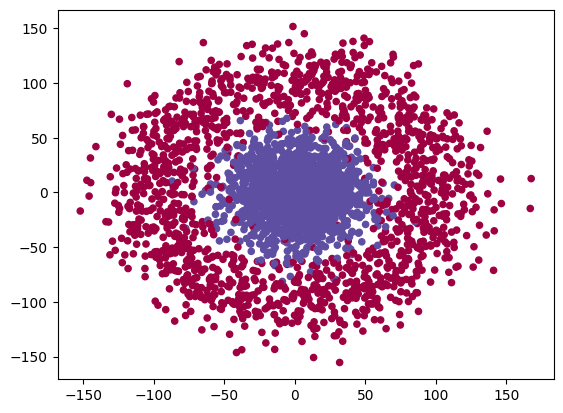

In [27]:
data = make_circles(n_samples=3000,     # cantidad de puntos a generar
                    noise=0.2,          # ruido gaussiano con esta desviación estándar 
                    factor=0.2,         # factor de separación entre los conjuntos
                    random_state=1      # semilla para que todos obtengamos resultados análogos
                    )

X, y = data     # definimos muestros datos de entrada y salida.

X = 100 * X     # Incrementamos la escala de los datos de entrada para que ejercicio incluya transformación de datos.

print(X.shape)
print(y.shape)

plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap=plt.cm.Spectral);   # Graficamos los datos.

Obseva que es un problema de clasificación donde un posible clasificador podría ser una curva en forma de elipse, es decir, una expresión cuadrática.

Utilizaremos la función de regresión logística a lo largo de este ejercicio como modelo de clasificación binario.

Los datos que se generaron están balanceados, pero verifiquemos que efectivamente tenemos la misma cantidad de datos en cada clase:

In [28]:
print('Total de datos generados:', y.shape[0])
print('Total de datos en la clase positiva', y.sum())
print('Total de datos en la clase negativa', (y.shape[0] - y.sum()))

Total de datos generados: 3000
Total de datos en la clase positiva 1500
Total de datos en la clase negativa 1500


###**Ejercicio 1: Partición de los datos**

1.   Paticiona el conjunto de datos en entrenamiento y prueba usando la función correspondiente de scikit-learn, con un $20\%$ en el de prueba y random_state=7. Solo utiliza estos argumentos. 


NOTA: Se aplicará validación cruzada, por lo que no es necesario por el momento generar el conjunto de validación de manera explícita.

In [29]:
from sklearn.model_selection import train_test_split


###############################################################################
###############################################################################
# INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
# Ejercicio 1
# Sustituye "None" por el código que se te indica.
# Recuerda que solo debes incluir tu código en lugar del "None" y no puedes
# modificar el resto del código.

# Ejercicio 1.1: Usa la función train_test_split de scikit-learn para obtener
# una partición con 20% de prueba y el resto para entrenamiento y validación. 
# Utiliza además una semilla igual a 7.
# Se espera una línea de código.

Xtv, Xtest, ytv, ytest = train_test_split(X,y, test_size=.20,random_state=7)

# TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
#########################################################


#**Parte 2: Curvas de aprendizaje incrementando el tamaño de la muestra**

En la actividad de esta semana vimos dos tipos de gráficos que nos ayudan a identificar el submuestreo y el sobremuestreo de un modelo mediante las llamadas curvas de aprendizaje. 

Una de las técnicas es ir aumentando poco a poco el tamaño del conjunto de entrenamiento e ir observando cómo se comportan las predicciones en los conjuntos de entrenamiento y validación. En scikit-learn se le llama a esta técnica curva de aprendizaje y se aplica con la función "learning_curve()".

Antes de continuar debes estudiar la actividad del Jupyter-Notebook de esta semana: "MNA_IAyAA_semana_4_Varianza_Sesgo_y_CurvasDeAprendizaje.html".

Como métrica utilizaremos la exactitud (accuracy) en este problema de clasificación balanceado. 

Nos estaremos apoyando en la función learning_curve() de scikit_learn para llevar a cabo este proceso. Revisa su decumentación en la siguiente liga: 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

###**MODELO DE REGRESIÓN LOGÍSTICO**

Utilizaremos el modelo de regresión logística de scikit-learn para construir un modelo que permita clasificar el conjunto de datos generado.


In [30]:
# Importemos los paquetes y módulos necesarios para poder continuar con esta actividad:

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler   
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve, validation_curve

Como estaremos graficando continuamente las curvas de aprendizaje, definimos una función para que nos facilite el proceso. 

Observa que estaremos graficando la exactitud en cada partición del método de VC y no el error. Obviamente también se pueden graficar los errores, pero en este caso nos estamos decidiento por el desempeño del modelo con la exactitud.

In [31]:
def mi_LearningCurvePlot(train_sizes, train_scores, val_scores):

    # Argumentos de entrada de la función mi_LearningCurvePlot:
    #      train_sizes : número de observaciones en el conjunto de entrenamiento.
    #      train_scores : Exactitud de cada partición en el proceso de Validación-Cruzada (VC) en los datos de entrenamiento.
    #                     La dimensión de este conjunto es (pxq) 
    #                                     donde p="número de particiones de manera incremental del conjunto de entrenamiento".
    #                                           q="número de particiones de VC" * "número de repeticiones de VC con RepitedStratifiedCV"
    #      val_scores : Exactitud de cada partición en el proceso de Validación-Cruzada en los datos de validación.
    #                   Es de la misma dimensión que los train_scores. 
    # Output: la salida es el gráfico con las curvas de aprendizaje.

    # Obtenemos los promedios y desviaciones estándar de cada renglón de los resultados de entrenamiento y validación
    # La dimensión de cada uno es p="número de particiones de manera incremental del conjunto de entrenamiento".
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Graficamos las curvas de aprendizaje incluyendo una región indicando la desviación estándar.
    plt.figure(figsize=(7,6))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
    
    plt.plot(train_sizes, val_mean, color='red', marker='+', markersize=5, linestyle='--', label='Validation')
    plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.1, color='red')
    
    plt.title('Curvas de Aprendizaje incrementando el tamaño de la muestra')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Exactitud (accuracy)')
    plt.grid()
    plt.legend(loc='lower left')
    plt.show()


Como generamos un conjunto de datos en un rango bastante amplio en sus variables de entrada (recuerda que al inicio una clase se generó como entre -150 y 150 y la otra como entre-50 y 50), se requiere escalarlos para evitar un desbordamiento de los datos durante el proceso de optimización. Por ello, deberás aplicar la transformación estándar de $(x - 𝜇) / \sigma$ (que proporciona scikit-learn mediante la función StandardScaler) a los datos de entrada. Además, para ayudar a evitar la filtración de datos (data leakage) deberás usar un pipeline (con Pipeline de scikit-learn) de dos pasos. Todas estas transformaciones deberás implementarlas en la secuencia que se te indica a continuación:

1.   Define un pipeline de dos pasos: primero el escalamiento usando la función StandardScaler, seguido del modelo de regresión logística definido previamente. Al primer paso llamarlo "escalar" y al segundo "modelo".

2.   A continuación aplicarás validación cruzada para el caso estratificado y con repeticiones, con la función RepeatedStratifiedKFold(). La estratificación es para obtener una distribución de clases homogénea en cada partición de VC y las repeticiones son para obtener un modelo más robusto. Deberás utilizar 5 particiones (splits) y 3 repeticiones, con una semilla igual a 7. Solo define y modifica estos argumentos.

3.   Ahora definirás un arreglo de NumPy de 40 puntos entre 0.1 y 1.0, usando la función linspace, el cual definirá los tamaños de los conjuntos de entrenamiento de manera incremental desde un 10% hasta el 100%.

4.   Completa los argumentos de la función learning_curve de scikit-learn que se te indican y que te permita generar los resultados de los conjuntos de entrenamiento y validación necesarios para generar las curvas de aprendizaje. 


Ya que el resto de los ejercicios será modificar simplemente los datos de entrada para observar cómo se afecta el desempeño del modelo con diferentes tamaños de muestra, estas líneas de código serán parte de una función que estaremos llamando en varias ocasiones y que definirás a continuación. 

Sobra decir que el resto de los ejercicios se basan en esta función, por lo que revisa bien la teoría estudiada esta semana para que puedas tener un buen resultado.

Igualmente consulta la documentación correspondiente de cada función utilizada:

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html

https://numpy.org/doc/stable/reference/generated/numpy.linspace.html

In [32]:
def mi_ModeloYCurvas(Xin):
       # Usemos primeramente el modelo de regresión logística
       # con sus parámetros predeterminados y semilla igual a 1.
       # Incremenetamos además el máximo de iteraciones para 
       # asegurar la convergencia de cada partición de la VC.

       modelo = LogisticRegression(max_iter=1000, random_state=1)

       ########################################################################
       # INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
       # Ejercicio 2
       # Sustituye "None" por el código que se te indica.
     
       # Ejercicio 2.1: Define el pipeline como se te indicó:
       # Se espera una línea de código.

       mi_pipe = Pipeline(steps=[
          ('escalar', StandardScaler()),
          ('modelo', modelo)
       ])

       # Ejercicio 2.2: Aplica validación cruzada estratificada y con repeticiones.
       #                Solo define los tres argumentos que se te indicaron.
       # Se espera una línea de código.

       mi_kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=7)

       # Ejercicio 2.3: Genera un arreglo con los 40 valores de los tamaños de muestra:
       # Se espera una línea de código.
       
       delta_train_sz = np.linspace(0.1, 1.0,num=40)


       # Ejercicio 2.4:: Incluye los argumentos que se te indican a la 
       # función learning_curve. Solo sustituye "None" por el valor del
       # argumento adecuado en cada caso.
       tr_sizes, tr_scores, val_scores = learning_curve(estimator = mi_pipe,    
                                                        X = Xin,
                                                        y = ytv,
                                                        cv = mi_kfold,
                                                        train_sizes = delta_train_sz,
                                                        random_state=11) 
       
       # TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
       ######################################################################

       # Obtenemos el gráfico con las curvas de aprendizaje:
       mi_LearningCurvePlot(tr_sizes, tr_scores, val_scores)



Curvas de aprendizaje del modelo lineal:


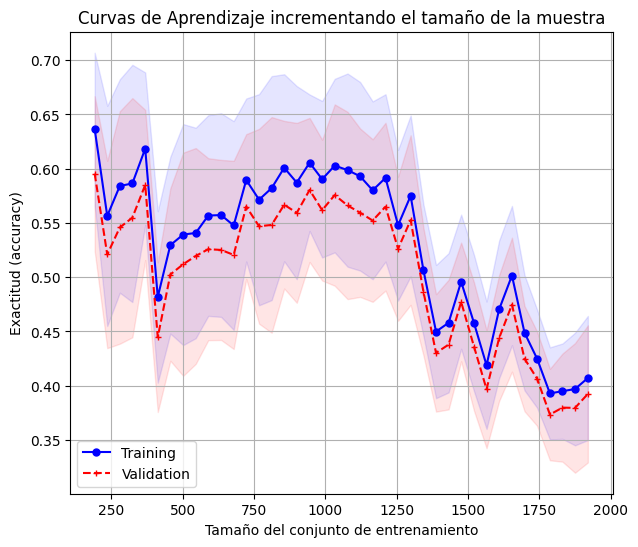

In [33]:
# Verifiquemos las curvas de entrenamiento que se obtienen con los datos de 
# entrenamiento y validación Xtv, para este primer modelo lineal:
print('Curvas de aprendizaje del modelo lineal:')
mi_ModeloYCurvas(Xtv)

### Ejercicio 2.5:
###**PREGUNTAS A RESPONDER DEL MODELO LINEAL:**
###Incluye en esta sección lo que observas y concluyes del gráfico de curvas de aprendizaje que acabas de obtener. En particular responde las siguientes preguntas. 

Sustituye "None" por tus respuestas y agrega tantas líneas como consideres necesario, siendo conciso y claro.



#################################################################
#### **INICIA LA SECCIÓN PARA AGREGAR TEXTO**

**¿Consideras que se obtuvo un buen modelo lineal? ¿o está subentrenado? ¿o sobreentrenado?**

Se obtubo un modelo subentrenado, el trainning tiene varianza baja respecto a la grafica de validación y un sesgo ligeramente alto. Sin embargo, por el tipo de comportamiento de la gráfica, podríamos decir que el modelo tambien esta sobreentrenado.

**¿El resultado era de esperarse? ¿Por qué?**

si, por el tipo de sistema, la frecuencia, rango y por el numero de muestras que se consideraron para el modelo.

##### **TERMINA LA SECCIÓN PARA AGREGAR TEXTO.**
######################################################################

###**MODELOS POLINOMIALES CUADRÁTICOS**

A partir del gráfico de los puntos generados al inicio de la actividad, observamos que la frontera de separación entre ambas clases tiene forma elíptica aproximadamente, es decir, la frontera de separación entre ambas clases se asemeja a una curva cuadrática. Así que en este apartado deberás proponer nuevos modelos polinomiales que premitan mejorar el problema de clasificación. Del primer resultado obtenido, vemos que el modelo está claramente subentrenado y sabemos que una de las sugerencias en dicho caso es agregar mayor complejidad. Por lo que estaremos agregando mayor complejidad incluyendo nuevas columnas de forma polinomial, iniciando con la cuadrática.

Para cada modelo polinomial definido estarás generando su gráfico de curvas de aprendizaje.

Una manera de generar modelos polinomiales con la variable de salida a partir de los datos de entrada, es estableciendo relaciones cuadráticas en dichas variables de entrada. Esto se puede lograr fácilmente si consideramos los datos de entrenamiento y validación Xtv como un DataFrame de Pandas y cuyas columnas llamaremos "x1" y "x2" como se indica a continuación:


In [34]:
dfX = pd.DataFrame(Xtv, columns=['x1','x2'])

dfX.head()

,x1,x2
0,-55.304310,-27.498075
1,-53.570164,116.983001
2,20.855563,115.805946
3,-27.499558,-28.829745
4,4.578928,-29.281716


Cuando uno utiliza las columnas de los factores numéricos para construir un modelo de regresión lineal por el método de mínimos cuadros, se pueden utilzar esas mismas columnas para generar modelos polinomiales. Por ejemplo, si nuestra matriz de datos de entrada $X$ está formada por las columnas $x_1, x_2, x_3$, y si la variable de salida la denotamos como $y$, los parámetros o pesos encontrados por el método de mínimos cuadrados $\beta_0, \beta_1, \beta_2, \beta_3$ nos permite expresar la relación encontrado como $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3$. Ahora, si agregamos por ejemplo una nueva columna a la matriz $X$ que esté formada por los cuadrados de los valores de la columna $x_1$ correspondientes y aplicamos nuevamente el método de mínimos cuadrados, encontramos una nueva relación lineal entre las columnas, pero cuadrática en cuanto la naturaleza de los factores, la cual ahora podríamos expresar como $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 +\beta_4 x{}^2_1$. Esta es una relación cuadrática o polinomial de los factores de entrada, con respecto a la variable de salida. 

Un función polinomial está dada por los cuadrados o productos cruzados de sus variables. Por ejemplo, $\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x{}^2_1 + \beta_4 x{}^2_2 + \beta_5 x_1 x_2$ incluye tres términos cuadráticos. A un término de la forma $x_1 x_2$ se les llama término cruzado y puedes incluir dicha relación al modelo de regresión, agregando una nueva columna que consista del producto de los valores de dichas variables correspondientes.

En los siguientes ejercicios se te pedirá que construyas modelos polinomiales de grados 2, 3 y 4 de esta manera, para observar la manera en que ayude a generar un nuevo modelo para predecir los valores de la variable de salida.   

###**Ejercicio 3: Modelos cuadráticos**

Usaremos el DataFrame dfX que acabamos de definir para construir modelos polinomiales agregándole columnas como se te indica a continuación en cada caso. Es decir, en cada caso construirás la nueva matriz de entrada y después se usarán las funciones recién definidas para generar y verificar si el modelo obtenido es adecuado o está subentrenado o sobreentrenado a partir de sus curvas de aprendizaje y validación. En todos los casos el total de renglones no se modifica y debe seguir siendo el mismo de dfX.

Observa que cada ejercicio es independiente de los demás, o en otras palabras, cada nuevo DataFrame nos generará un nuevo modelo. Recordemos que las dos columnas del DataFrame dfX inicial, se llaman "x1" y "x2". Agrega las nuevas columnas como se te indica a continuación en cada inciso y DataFrame:


1.   **Primer DataFrame:** Agregar una tercera columna a dfX que esté formada por los cuadrados de la columna uno. Llamaremos "x12" a dicha columna. Puedes llevar a cabo la operación como producto de columnas o como potencia de una columna usando la función de power de NumPy. Es decir, la nueva matriz deberá tener tres columnas, las primeras dos seguirán siendo "x1" y "x2" y la tercera será el cuadrado de la primera. Llamar al nuevo DataFrame dfx12.

2.   **Segundo DataFrame:** La nueva matriz está formada por 3 columnas, "x1" y "x2" y la tercer columna es el cuadrado ahora de la segunda columna, que llamaremos "x22". Llamar al nuevo DataFrame dfx22.

3.   **Tercer DataFrame:** La nueva matriz está formada por 3 columnas, "x1" y "x2" y la tercera columna estará formada por el producto cruzado de estas dos primeras variables y llamaremos "x1x2" a la nueva columna. Llamar al nuevo DataFrame dfx1x2.

4. **Cuarto DataFrame:** La nueva matriz está formada por 4 columnas, las dos primeras siguen siendo "x1" y "x2" y la tercera y cuarta son los cuadrados de "x1" y "x2, que llamaremos "x12" y "x22", respectivamente. Llamar al nuevo DataFrame dfx12x22.

5.    **Quinto DataFrame:** La nueva matriz está formada solo por dos columnas, que son "x1" al cuadrado y "x2" al cuadrado. Las nuevas columnas deben llamarse "x12" y "x22". Llamar al nuevo DataFrame dfsolox12x22.








In [35]:
# Hacemos una copia de los datos originales para conservarlos de esta manera y
# llamamos a los nuevos DataFrames como se nos dice en cada caso, para llevar
# a cabo las propuestas polinomiales:

dfx12 = dfX.copy()
dfx22 = dfX.copy()    
dfx1x2 = dfX.copy()
dfx12x22 = dfX.copy()
dfsolox12x22 = dfX.copy()   

# Para tener la lista de los nombres de cada caso:
nombres = list()

# Además, desplegaremos un par de renglones del DataFrame resultante para 
# que vayas observando si los resultados obtenidos son los esperados.

########################################################################
# INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
# Ejercicio 3
# Sustituye "None" por el código que se te indica.
# Recuerda que solo debes incluir tu código en lugar del "None" y  
# no puedes modificar el resto del código.
# En cada caso se esperan 2 o cuando mucho 3 líneas de código.

# Ejercicio 3.1: Define dfx12 como se te indicó previamente:

dfx12.loc[:,'x12']= np.power(dfx12['x1'],2)

nombres.append('Ejercicio 3.1: dfx12: cuadrática en x1:')  
print(dfx12.head(2))  # desplegamos los dos primeros renglones en cada caso.


# Ejercicio 3.2: Define dfx22 como se te indicó previamente:

dfx22.loc[:,'x22']= np.power(dfx22['x2'],2)


nombres.append('Ejercicio 3.2: dfx22: cuadrática en x2:')
print(dfx22.head(2))



# Ejercicio 3.3: Define dfx1x2 como se te indicó previamente:

x1x2=dfx1x2['x1']*dfx1x2['x2']
dfx1x2.loc[:,'x1x2']= x1x2

nombres.append('Ejercicio 3.3: dfx1x2: producto cruzado:')
print(dfx1x2.head(2))

# Ejercicio 3.4: Define dfx12x22 como se te indicó previamente:

dfx12x22.loc[:,'x12']= np.power(dfx12x22['x1'],2)
dfx12x22.loc[:,'x22']= np.power(dfx12x22['x2'],2)


nombres.append('Ejercicio 3.4: dfx12x22: cuadráticas en x1 y x2:')
print(dfx12x22.head(2))

# Ejercicio 3.5: Define dfsolox12x22 como se te indicó previamente:
dfsolox12x22=pd.DataFrame(dfx12x22, columns=['x12','x22'])


nombres.append('Ejercicio 3.5: dfsolox12x22: solo las cuadráticas en x1 y x2:')
print(dfsolox12x22.head(2))

# TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
######################################################################



          x1          x2          x12
0 -55.304310  -27.498075  3058.566703
1 -53.570164  116.983001  2869.762455
          x1          x2           x22
0 -55.304310  -27.498075    756.144134
1 -53.570164  116.983001  13685.022538
          x1          x2         x1x2
0 -55.304310  -27.498075  1520.762069
1 -53.570164  116.983001 -6266.798535
          x1          x2          x12           x22
0 -55.304310  -27.498075  3058.566703    756.144134
1 -53.570164  116.983001  2869.762455  13685.022538
           x12           x22
0  3058.566703    756.144134
1  2869.762455  13685.022538


Ejercicio 3.1: dfx12: cuadrática en x1:


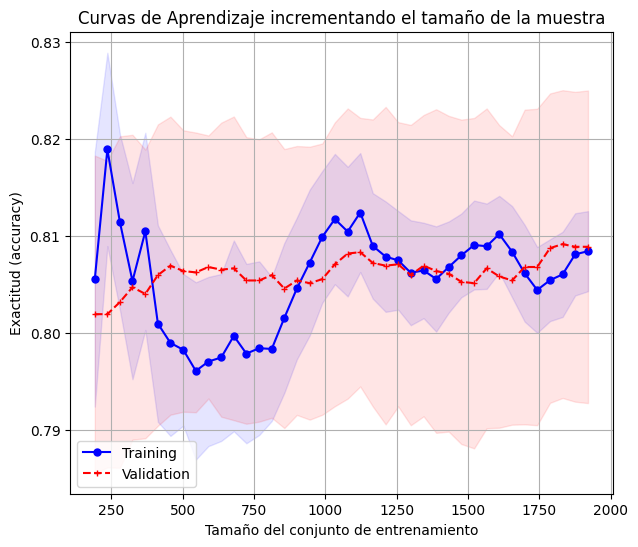

Ejercicio 3.2: dfx22: cuadrática en x2:


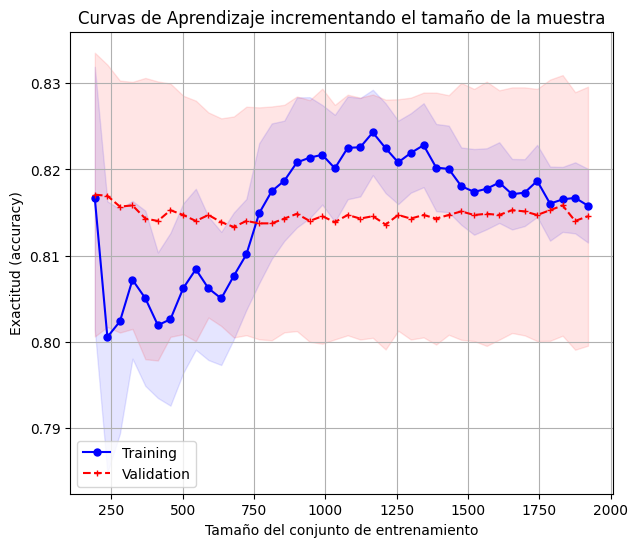

Ejercicio 3.3: dfx1x2: producto cruzado:


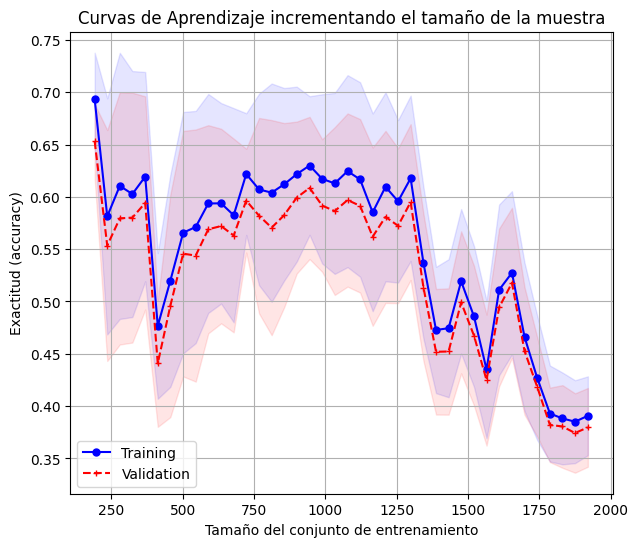

Ejercicio 3.4: dfx12x22: cuadráticas en x1 y x2:


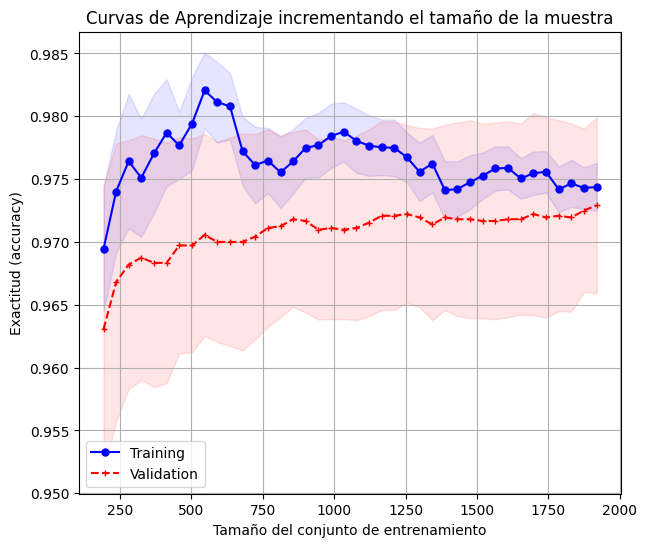

Ejercicio 3.5: dfsolox12x22: solo las cuadráticas en x1 y x2:


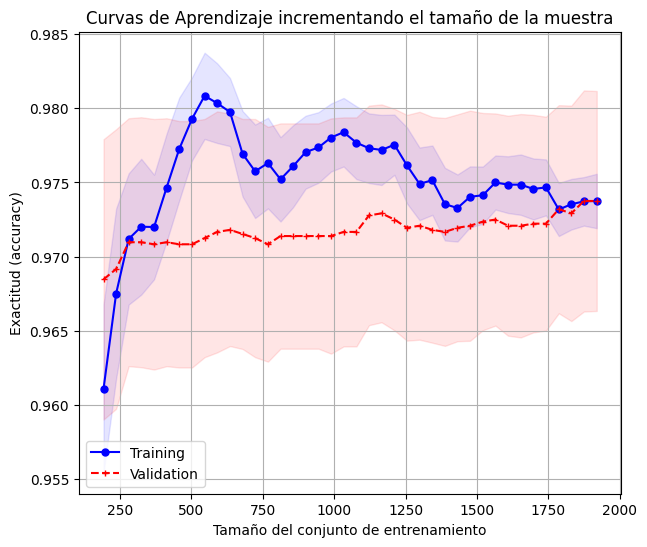

In [36]:
# Se entrena y grafican las curvas de aprendizaje que 
# acabas de generar para cada uno de los 5 casos:


print(nombres[0])
mi_ModeloYCurvas(dfx12)

print(nombres[1])
mi_ModeloYCurvas(dfx22)

print(nombres[2])
mi_ModeloYCurvas(dfx1x2)

print(nombres[3])
mi_ModeloYCurvas(dfx12x22)

print(nombres[4])
mi_ModeloYCurvas(dfsolox12x22)



### Ejercicio 3.6:
###**PREGUNTAS A RESPONDER DEL MODELO CUADRÁTICO:**
###Incluye en esta sección lo que observas y concluyes de los gráficos obtenidos previamente. En particular responde las siguientes preguntas.


Sustituye "None" por tus respuestas y agrega tantas líneas como consideres necesario, siendo conciso y claro.



#################################################################
#### **INICIA LA SECCIÓN PARA AGREGAR TEXTO**

*   **¿Consideras que los modelos cuadráticos en general son una mejor propuesta en comparación al modelo lineal? ¿Era de esperarse? ¿Por qué?**

Depende de cual de los sistemas cuadráticos tomemos como referencia, lo que si podemos observar en ellos es que de alguna forma los datos a pesar de tener alta varianza en un inicio, tienden a acercarse las curvas de training y de validación conforme va pasando el periodo y mantienen una curva más estable.

Era de esperarse, debido al tipo de disperción que muestran los datos.

*  **¿Cuál consideras que fue el mejor de ellos?**

En mi opinion, tiende a mantener mas estabilidad el grafico del ejercicio 3.4(dfx12x22) aunque presenta al inicio una varianza relativamente alta, se va estabilizando y no se encuentran a gran distancia sus muestreos pero sobre todo, se van acercando sus lineas de validación y training generando cada vez menor varianza y su sesgo no esta tan alto.


*   **¿Consideras que deben incluirse los términos lineales en general cuando se considera un modelo cuadrático?**
si, para poder realizar comparativos o complementar el analisis.

**En particular compara el resultado de dfsolox12x22 con el de dfx12x22 ¿con cuál de estos dos te quedarías?**

me quedaría con el modelo de dfx12x22. 

*   **¿Cuáles consideras que fueron buenos modelos y cuáles están subentrenados o sobreentrenados?**

el modelo dfx12x22 del ejercicio 3.4, presenta un grafico más estable.
el modelo del ejercicio 3.5, a pesar de tener un pico al arranque, tambien tiende a presentar un grafico con tendencia a la estabilización sin embargo, pareciera más un sistema sobreentrenado como la mayoria.



##### **TERMINA LA SECCIÓN PARA AGREGAR TEXTO.**
######################################################################

###**MODELOS CÚBICOS Y GRADO 4**

De manera análoga ahora veremos solo unas cuántas de las combinaciones con las potencias de grado 3 y 4 en x1 y x2.

Esto nos podrá dar una idea de si el modelo puede seguir mejorándose con este tipo de propuestas y de ser así, se podrán proponer algunas más.


###**Ejercicio 4: Modelos polinomiales de grados 3 y 4**

De manera análoga usaremos ahora el DataFrame dfX para construir modelos polinomiales de grados 3 y 4. En esta ocasión solo veremos algunos de dichos casos, pero tú podrías intentar probar algunas otras combinaciones. 

Recuerda que las dos columnas del DataFrame dfX se llaman "x1" y "x2".


1.   **Primer DataFrame:** La nueva matriz está formada por 4 columnas, las dos primeras siguen siendo "x1" y "x2" y la tercera y cuarta son las potencias cúbicas de "x1" y "x2, que llamaremos "x13" y "x23", respectivamente. Llamar al nuevo DataFrame dfx13x23.

2.   **Segundo DataFrame:** La nueva matriz está formada por 6 columnas, las dos primeras siguen siendo "x1" y "x2", la tercera y cuarta, y la quinta y sexta, son las potencias cuadradas y cúbicas de cada uno de estos factores iniciales, respectivamente. Llamar a estas nuevas columnas "x12", "x22", "x13" y "x23" y al nuevo DataFrame llamarlo dfpotencias2y3.

3.   **Tercer DataFrame:** La nueva matriz está formada por 4 columnas, las dos primeras siguen siendo "x1" y "x2" y la tercera y cuarta son las potencias cuartas de "x1" y "x2, que llamaremos "x14" y "x24", respectivamente. Llamar al nuevo DataFrame dfx14x24.


In [37]:
# Hacemos una copia de los datos originales para conservarlos de esta manera y
# llamamos a los nuevos DataFrames como se nos dice en cada caso, para llevar
# a cabo las propuestas polinomiales:

dfx13x23 = dfX.copy() 
dfpotencias2y3 = dfX.copy()    
dfx14x24 = dfX.copy()


# Para tener la lista de los nombres de cada caso:
nombres = list()

########################################################################
# INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
# Ejercicio 4
# Sustituye "None" por el código que se te indica.
# Recuerda que solo debes incluir tu código en lugar del "None" y  
# no puedes modificar el resto del código.
# En cada caso se esperan cuando mucho 6 líneas de código.


# Deberás desplegar un par de renglones del DataFrame resultante para 
# observar cada uno de los resultados obtenidos.

# Ejercicio 4.1: Define dfx13x23 como se te indicó previamente y anexa el nombre
#                de este caso a la lista "nombres". Imprime además los primeros 
#                dos renglones del DataFrame resultante:

dfx13x23.loc[:,'x13']= np.power(dfX['x1'],3)
dfx13x23.loc[:,'x23']= np.power(dfX['x2'],3)
nombres.append('Ejercicio 4.1: dfx13x23: producto cubico:')
print(dfx13x23.head(2))


# Ejercicio 4.2: Define dfpotencias2y3 como se te indicó previamente y anexa el 
#                nombre de este caso a la lista "nombres". Imprime además los 
#                primeros dos renglones del DataFrame resultante::
dfpotencias2y3.loc[:,'x12']= np.power(dfX['x1'],2)
dfpotencias2y3.loc[:,'x22']= np.power(dfX['x2'],2)
dfpotencias2y3.loc[:,'x13']= np.power(dfX['x1'],3)
dfpotencias2y3.loc[:,'x23']= np.power(dfX['x2'],3)
nombres.append('Ejercicio 4.2: dfpotencias2y3: potencias cuadradas y cubicas')
print(dfpotencias2y3.head(2))




# Ejercicio 4.3: Define dfx14x24 como se te indicó previamente y anexa el nombre
#                de este caso a la lista "nombres". Imprime además los primeros 
#                dos renglones del DataFrame resultante::
dfx14x24.loc[:,'x14']= np.power(dfX['x1'],4)
dfx14x24.loc[:,'x24']= np.power(dfX['x2'],4)
nombres.append('Ejercicio 4.3: dfx14x24: prod:')
print(dfx14x24.head(2))




# TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
######################################################################

          x1          x2            x13           x23
0 -55.304310  -27.498075 -169151.921083 -2.079251e+04
1 -53.570164  116.983001 -153733.644910  1.600915e+06
          x1          x2          x12           x22            x13  \
0 -55.304310  -27.498075  3058.566703    756.144134 -169151.921083   
1 -53.570164  116.983001  2869.762455  13685.022538 -153733.644910   

            x23  
0 -2.079251e+04  
1  1.600915e+06  
          x1          x2           x14           x24
0 -55.304310  -27.498075  9.354830e+06  5.717540e+05
1 -53.570164  116.983001  8.235537e+06  1.872798e+08


Ejercicio 4.1: dfx13x23: producto cubico:


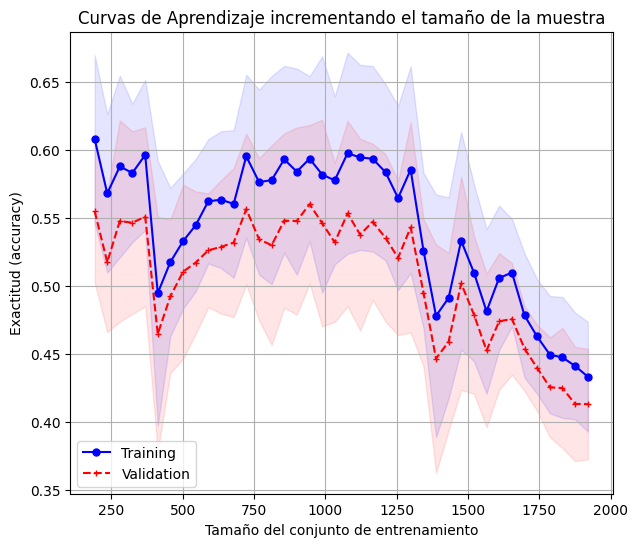

Ejercicio 4.2: dfpotencias2y3: potencias cuadradas y cubicas


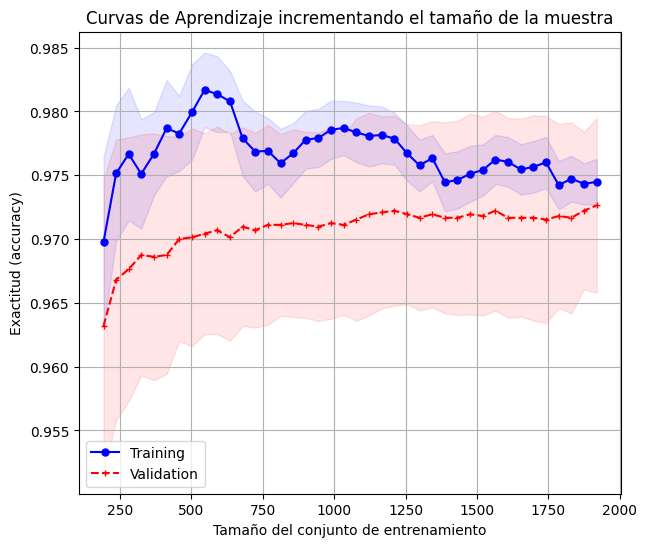

Ejercicio 4.3: dfx14x24: prod:


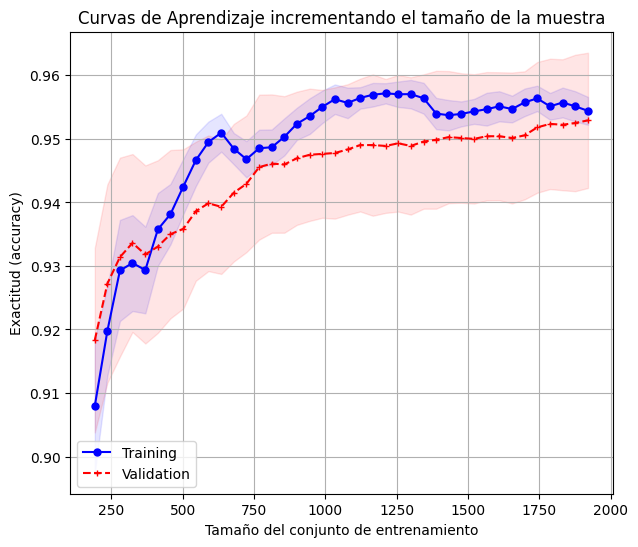

In [38]:
# Se entrena y grafican las curvas de aprendizaje que acabas de generar:


print(nombres[0])
mi_ModeloYCurvas(dfx13x23)

print(nombres[1])
mi_ModeloYCurvas(dfpotencias2y3)

print(nombres[2])
mi_ModeloYCurvas(dfx14x24)

### Ejercicio 4.4:
###**PREGUNTAS A RESPONDER DE LOS MODELOS DE GRADO 3 Y 4:**
###Incluye en esta sección lo que observas y concluyes de los resultados obtenidos. En particular responde las siguientes preguntas.


Sustituye "None" por tus respuestas y agrega tantas líneas como consideres necesario, siendo conciso y claro.



#################################################################
#### **INICIA LA SECCIÓN PARA AGREGAR TEXTO**

*   **¿Consideras que se obtuvo un buen modelo en el caso cúbico o con los de grado 4?**
no tanto como en los de potencia 2.
*   **¿Cuál consideras que fue el mejor de los tres generados?**

en esta sección considero mejor el modelo del ejercicio 4.3
*   **¿En particular, consideras que alguno de estos modelos es mejor que el del ejercicio 3 anteririor, de términos cuadráticos?**

No

*   **¿Cuáles consideras que fueron buenos modelos y cuáles están subentrenados o sobreentrenados?**
Los modelos cuadraticos y de cuarta potencia tienen un comportamiento mayormente estable, por lo que son metodos que podríamos considerar buenos para el analisis.

Aunque algunos modelos pudieran no tener cerca ambas curvas, al final estas precentan un acercamiento, por lo que podríamos decir que los sistemas estan subentrenados.

*  **¿En general cuál consideras que es el mejor de todos los modelos obtenidos: el lineal, o alguno de los cuadráticos, cúbicos o de grado 4?**

El cuadratico 3.4 y 4.3 de potencia cuatro, a pesar de sus sesgos ligeramente altos, muestran un comportamiento más estable y con datos sin tanta varianza.


##### **TERMINA LA SECCIÓN PARA AGREGAR TEXTO.**
######################################################################

#**Parte - 3: Modelo final y conclusiones**

Conjuntemos toda la información realizada hasta ahora para obtener nuestro mejor modelo sin subentrenamiento o sobreentrenamiento.

##Ejercicio 5: Generando el mejor modelo:

Finalmente, con base a toda la información obtenida, seleccionarás el mejor modelo, lo cual consiste en seleccionar el mejor conjunto de datos de entrada y el mejor valor del hiperparámetro para llevar a cabo el entranamiento con los datos de entrenamiento y validación. 
Se usará depués el conjunto de prueba (test) que no hemos utilizado hasta ahora, para obtener el desempeño final del modelo. 

1.   Selecciona los datos de entrada que consideres fueron los que generaron el mejor modelo polinomial para usarlos como datos de entrenamiento. Lo llamaremos dfXmejorTrain.

2.   Transforma los datos de prueba Xtest en un DataFrame de Pandas llamado dfXtest y cuyas columnas se llamen "x1" y "x2".

3.   Aplica ahora al conjunto de prueba dfXtest lo que se decidió con el conjunto de entrenamiento para generar el mejor modelo polinomial, es decir, agrega a dfXtest las columnas análogas a las de dfXmejorTrain.

4.   Selecciona el mejor valor del parámetro de regularización C encontrado en el mejor gráfico de las curvas de validación. Lo llamaremos "C_mejor".

5.   Selecciona el mismo Pipeline, llamado "mi_pipe", que definiste en el ejercicio 2.

Finalmente se obtiene el desempeño final del modelo polinomial con el conjunto de prueba. Se calcula además el desempeño del conjunto de entrenamiento para verificar lo que ya hemos validado con los análisis anteriores, de si el modelo es adecuado o si está subentrenado o sobreentrenado.

Observa que ya no se está usando Validación-Cruzada, porque ya no se desean realizar comparaciones entre modelos, si no generar el modelo final con los mejores hiperparámetros enocntrados.

In [40]:
Xtest

array([[  4.99214447,  29.98151602],
       [  4.53328107,   5.13205056],
       [-91.77453545, -59.85654623],
       ...,
       [-25.06623836,  42.9347935 ],
       [ 83.24921103,  -3.06145898],
       [141.30728644, -15.94919667]])

In [44]:
########################################################################
# INICIA LA SECCIÓN PARA AGREGAR CÓDIGO.
# Ejercicio 5
# Sustituye "None" por el código que se te indica.
# Recuerda que solo debes incluir tu código en lugar del "None" y  
# no puedes modificar el resto del código.

# Ejercicio 5.1: Utiliza el que consideres fue el mejor conjunto de datos de 
#                entrenamiento de entrada. Es decir, selecciona el mejor DataFrame
#                que hayas encontrado en los ejercicios anteriores. 
#                NOTA: Debe ser simplemente el nombre de alguno de los DataFrame
#                       que ya hayas definido previamente. Lo llamaremos dfXmejorTrain.
# Se espera una línea de código:

dfXmejorTrain = dfx12x22



# Ejercicio 5.2: Define el conjunto prueba Xtest como un DataFrame y nombra a 
#                sus columnas como "x1" y "x2". Lo llamaremos dfXtest.
# Se espera una línea de código:

dfXtest= pd.DataFrame(Xtest,columns=['x1','x2'])

# Ejercicio 5.3: Agrega las nuevas columnas a dfXtest transformándolas de la 
#                misma manera que se transformaron y agregaron las columnas 
#                para obtener el DataFrame del ejercicio 5.1.
#                Haremos una copia del conjunto de prueba para no modificar 
#                los datos originales.
# Sustituye None por tus líneas de código. Se esperan al menos 2 líneas de código:

dfXtestpoli = dfXtest.copy()
dfXtestpoli['x12']= np.power(dfXtest['x1'],2)
dfXtestpoli['x22']= np.power(dfXtest['x2'],2)

modeloFinal = LogisticRegression(max_iter=1000, random_state=1)

# Ejercicio 5.4: Define y utiliza de nuevo el mismo pipeline del ejercicio 2: 
# Se espera una línea de código.

mi_pipe = Pipeline(steps=[('escalar', StandardScaler()),('modelo', modeloFinal)])

      
       # TERMINA LA SECCIÓN PARA AGREGAR CÓDIGO.
       ######################################################################



# Llevemos ahora la generación del modelo con el conjunto de entrenamiento:
mi_pipe.fit(dfXmejorTrain, ytv)

print('Exactitud del mejor modelo en el conjunto de entrenamiento: %.2f%%' % (100 * mi_pipe.score(dfXmejorTrain, ytv)))

print('Exactitud del mejor modelo en el conjunto de prueba: %.2f%%' %  (100*mi_pipe.score(dfXtestpoli, ytest)))


Exactitud del mejor modelo en el conjunto de entrenamiento: 97.42%
Exactitud del mejor modelo en el conjunto de prueba: 96.67%


### Ejercicio 5.5:

###**PREGUNTAS Y CONCLUSIONES FINALES:**


```
# Tiene formato de código

```
# Tiene formato de código
```


```


###Incluye tus conclusiones finales del modelo final generado, en particular indica si crees que se obtuvo un buen modelo o si está subentrenado o sobreentrenado.



Sustituye "None" por tus respuestas y agrega tantas líneas como consideres necesario, siendo conciso y claro.

#################################################################
#### **INICIA LA SECCIÓN PARA AGREGAR TEXTO**

El metodo cuadratico y de potencia 4, se adaptaron mejor a este analisis.
El modelo 3.4 es el más apto para este analisis.

###**--Fin de la actividad de la semana 4--**